This code requires Python 3.8

In [2]:
#Read the reduced database
!pip install openpyxl
!pip install --upgrade openpyxl

In [3]:
import pickle
data = pickle.load(open('full_data_corrected_2024.pkl', 'rb'))
print(data)
print(data.keys)
print(data.items)

{'I': [array([-0.018, -0.021, -0.018, ...,  0.036,  0.03 ,  0.024]), array([-0.018, -0.018, -0.018, ..., -0.015, -0.015, -0.012]), array([ 0.015,  0.012,  0.009, ..., -0.015, -0.003,  0.006]), array([-0.036, -0.033, -0.033, ...,  0.063,  0.063,  0.063]), array([-0.009, -0.006,  0.   , ..., -0.054, -0.051, -0.051]), array([-0.042, -0.042, -0.039, ...,  0.024,  0.024,  0.021]), array([ 0.078,  0.075,  0.075, ..., -0.027, -0.024, -0.018]), array([-0.042, -0.042, -0.042, ..., -0.036, -0.036, -0.036]), array([-0.339, -0.333, -0.321, ..., -0.042, -0.042, -0.042]), array([-0.006, -0.003,  0.   , ..., -0.045, -0.045, -0.042]), array([-0.024, -0.033, -0.033, ..., -0.042, -0.036, -0.03 ]), array([-0.081, -0.084, -0.087, ...,  0.009,  0.009,  0.006]), array([-0.024, -0.021, -0.021, ..., -0.006, -0.003,  0.   ]), array([-0.099, -0.09 , -0.087, ..., -0.03 , -0.027, -0.024]), array([-0.009, -0.012, -0.006, ..., -0.009, -0.012, -0.012]), array([0.   , 0.006, 0.012, ..., 0.039, 0.039, 0.039]), array([

In [4]:
#Read the table with the labels for the specific SOO
import pandas as pd
Specific_SOO = data['SOO'].copy()
template     = pd.read_excel('labels_FontiersUnsupervised.xlsx', sheet_name='Hoja2')

In [5]:
#Create a list with the specific SOO depending on the original label
Simplified_SOO = []
for SOO in Specific_SOO:
    idxs = template.index[template['SOO'] == SOO].tolist()
    if len(idxs) != 0:
        Simplified_SOO.append(template.iloc[idxs[0]]['Simplified'])
    else:
        Simplified_SOO.append('-') #Not recognized or nor annotated

In [6]:
#Cases per origin (There are few cases from origins in the AoC, such as LCC or RCC)
counter = {i:Simplified_SOO.count(i) for i in Simplified_SOO}
print(counter)


{'LVOTSUBVALVULAR': 22, 'RVOTFREEWALL': 44, 'RCC': 9, 'RVOTSEPTUM': 59, 'LCC': 9, 'COMMISURE': 15, 'LVOTSUMMIT': 22, '-': 1}


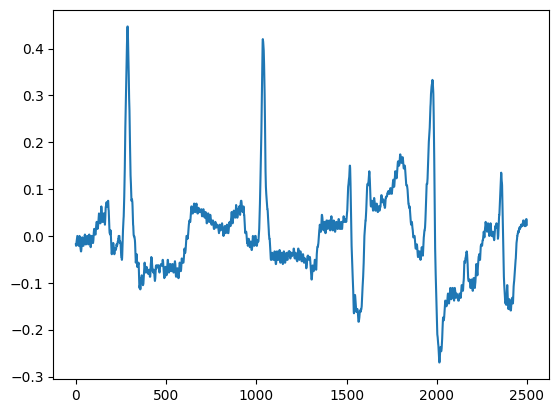

In [7]:
#Example on how to plot a single signal from the database
import matplotlib.pyplot as plt
plt.plot(data['I'][0]);

:SAK needs to be installed from a repository by running pip install git+https://github.com/guillermo-jimenez/sak.git


In [8]:
#Example with ECG segmentation
import torch
import sak
from functools import partial
import math
import scipy as sp
import skimage
import skimage.util
from typing import List,Tuple
import numpy as np
models_ECG = [
    torch.load(f"modelos/model.{i+1}") for i in range(5)
]

/var/folders/0m/69bwmd0n7zb8s8km1v5yycv00000gn/T/ipykernel_12882/736087579.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"modelos/model.{i+1}") for i in r

ModuleNotFoundError: No module named 'timm'

In [ ]:
def predict_ecg(ecg: np.ndarray, fs: float, model: List[torch.nn.Module],
                window_size: int = 2048, stride: int = 256, threshold_ensemble: float = 0.5,
                thr_dice=0.9, percentile=95, ptg_voting = 0.5, batch_size = 16,
                normalize=True, norm_threshold: float = 1e-6, filter = True) -> np.ndarray:
    """This function is used to delineate an ECG recording of arbitrary size ('ecg' variable, SAMPLES x LEADS)
    and to obtain the fiducials for the P, QRS and T segments as a binary mask of shape 3 x SAMPLES.

    Inputs:
    ecg                <- some array, e.g. shape 198484 x 12
    fs                 <- sampling frequency, e.g. 1000Hz. Will downsample to 250Hz for the AI model to work
    model              <- list of segmentation models for the ensemble
    window_size        <- the "chunk" size that will be processed at a time of the input ecg (e.g., in the example,
                          2048 samples out of the 198484 samples of the ECG)
    stride             <- the "stride" parameter allows for some overlap between the windows of the window_size
    threshold_ensemble <- Percentage of voting for the AI ensemble [0-1]
    thr_dice           <- Threshold for considering each sample as positive according to the Dice score
    percentile         <- Percentile for the amplitude normalization
    ptg_voting         <- Threshold for considering each sample as positive according to the Dice score
    batch_size         <- Number of windows that fit in the batch
    normalize          <- Boolean to indicate whether the ECG has to be normalized. In general, set this to True
                          always, as the ECGs must have the amplitude of a normal sinus rhythm around amplitude of
                          "1" to work, as that was the preprocessing for model training. Only change if a
                          comparable pre-processing is performed
    norm_threshold     <- Threshold for the normalization, to avoid passing baseline wander or noise as signal
    filter             <- Filter the signal with a band-pass filter in [0.5-125] Hz
    """
    # Preprocess signal
    ecg = np.copy(ecg).squeeze()
    if ecg.ndim == 0:
        return np.array([])
    elif ecg.ndim == 1:
        ecg = ecg[:,None]
    elif ecg.ndim == 2:
        if ecg.shape[0] < ecg.shape[1]:
            ecg = ecg.T
    else:
        raise ValueError("2 dims max allowed")
    ecg_250 = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[0]*250/fs),axis=0)


    # Pad if necessary
    if ecg_250.shape[0] < window_size:
        padding = math.ceil(ecg_250.shape[0]/window_size)*window_size-ecg_250.shape[0]
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')
    if (ecg_250.shape[0]-window_size)%stride != 0:
        padding = math.ceil((ecg_250.shape[0]-window_size)/stride)*stride-(ecg_250.shape[0]%window_size)
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')

    # Get dimensions
    N,L = ecg_250.shape

    # (Optional) Normalize amplitudes
    if normalize:
        # Get ecg_250 when it's not flat zero
        norm_signal = ecg_250[np.all(np.abs(np.diff(ecg_250,axis=0,append=0)) >= norm_threshold,axis=1),:]

        # High pass filter normalized ecg_250 to avoid issues with baseline wander
        norm_signal = sp.signal.filtfilt(*sp.signal.butter(2, 0.5/250., 'high'),norm_signal, axis=0)

        # Compute amplitude for those segments
        amplitude = np.array(sak.signal.moving_lambda(
            norm_signal,
            256,
            partial(sak.signal.amplitude,axis=0),
            axis=0
        ))
        amplitude = amplitude[np.all(amplitude > norm_threshold,axis=1),]
        amplitude = np.percentile(amplitude, percentile, axis=0)

        # Apply normalization
        ecg_250 = ecg_250/amplitude[None,:]

    # (Optional) Filter ecg_250
    if filter:
        ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2,   0.5/250., 'high'),ecg_250,axis=0)
        ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2, 125.0/250.,  'low'),ecg_250,axis=0)
        ecg_250 = sp.signal.lfilter(*sp.signal.iirnotch(50,20.0,250.),ecg_250,axis=0)
        ecg_250 = sp.signal.lfilter(*sp.signal.iirnotch(60,20.0,250.),ecg_250,axis=0)

    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(ecg_250.strides) < 0):
        ecg_250 = ecg_250.copy()

    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(ecg_250,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=int)

    # Check device for segmentation
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Compute segmentation for all leads independently
    with torch.no_grad():
        if isinstance(model,list):
            for m in model:
                m = m.to(device)
                for i in range(0,windowed_signal.shape[0],batch_size):
                    inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).float().to(device)}
                    outputs = m(inputs)["sigmoid"].cpu().detach().numpy()
                    windowed_mask[i:i+batch_size] += outputs > thr_dice
            windowed_mask = windowed_mask >= len(model)*threshold_ensemble
        else:
            model = model.to(device)
            for i in range(0,windowed_signal.shape[0],batch_size):
                inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).to(device).float()}
                outputs = model(inputs)["sigmoid"].cpu().detach().numpy()
                windowed_mask[i:i+batch_size] = outputs > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation_250 = np.zeros((3,N))

    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation_250[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation_250 = ((segmentation_250/counter) >= (ecg_250.shape[-1]*ptg_voting))

    # Correct padding
    segmentation_250 = segmentation_250[:,:-padding]

    # Interpolate back to original sampling frequency
    segmentation     = sak.signal.interpolate.interp1d(segmentation_250,ecg.shape[0],axis=-1,kind="nearest")

    return segmentation


In [ ]:
#Transform the signal from dictionary to numpy array
from sak.signal import StandardHeader
ecg_signals = []
for lead in StandardHeader:
    ecg_signals.append(data[lead][0])
ecg_signals = np.asarray(ecg_signals).T

In [ ]:
#Apply the segmentation for a single record (make function to apply to multiple signals)
fs = 1000
fs_high,fs_low = 0.5,100.0
ecg_250 = sak.signal.interpolate.interp1d(ecg_signals,round(ecg_signals.shape[0]*250/fs), axis=0).T
ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2, fs_high/250., 'high'), ecg_250, axis=-1)
ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2,  fs_low/250.,  'low'), ecg_250, axis=-1)

segmentation_250 = predict_ecg(ecg_250,250.,models_ECG,normalize=True,filter=False)

segmentation = sak.signal.interpolate.interp1d(segmentation_250,ecg_signals.shape[0],axis=-1,kind="nearest")

In [ ]:
#Plot all the signals
fig, ax = plt.subplots(4,3)
row = 0
col = 0
x = np.linspace(0,2.5,int(fs*2.5))
for i,sig in enumerate(ecg_signals.T):
    ax[row,col].plot(x, sig)
    ax[row,col].fill_between(x, np.min(sig), np.max(sig), where=(segmentation[0,:] == 1), color='C0', alpha = 0.3 )
    ax[row,col].fill_between(x, np.min(sig), np.max(sig), where=(segmentation[1,:] == 1), color='C1', alpha = 0.3 )
    ax[row,col].fill_between(x, np.min(sig), np.max(sig), where=(segmentation[2,:] == 1), color='C2', alpha = 0.3 )
    col += 1
    if col >= 3:
        row += 1
        col = 0

In [ ]:
#Plot a single signal
plt.plot(x, sig)
plt.fill_between(x, np.min(sig), np.max(sig), where=(segmentation[0,:] == 1), color='C0', alpha = 0.3 );
plt.fill_between(x, np.min(sig), np.max(sig), where=(segmentation[1,:] == 1), color='C1', alpha = 0.3 );
plt.fill_between(x, np.min(sig), np.max(sig), where=(segmentation[2,:] == 1), color='C2', alpha = 0.3 );


In [ ]:
#Load the full dataset, useful if you have few cases.
#BE CAREFUL WHEN SPLITTING THE CASES SO YOU DON'T HAVE THE SAME PATIENT IN BOTH TRAIN AND TEST
data = pickle.load(open('all_data_predicted_2024.pkl', 'rb'))

In [ ]:
#Structure of the dictionary to reach the ECG signals
data['P186']['Structures']['1-AO']['P3'].keys()

In [ ]:
#This way, the simplified version of the specific SOO is in the key-route: patient - Simplified_SOO
template     = pd.read_excel('labels_FontiersUnsupervised.xlsx', sheet_name='Hoja2')
for patient in data.keys():
    idx_patient = int(patient[1:]) - 1
    data[patient]['Simplified_SOO'] =  template.iloc[idx_patient]['Simplified']